In [1]:
import math
import csv
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#thermodynamic parameters

T0_air = 700.0 #air temperature [K]
T0_ch4 = 300.0 #methane temperature [K]
p0 = 2500000.0 #inlet preassure[Pa]
eqv = 0.8 #equivalence ratio
ftar = 1 / 17.2 #fuel to air ratio
X = 0.6 #mixer/DZ air injection ratio
air_mf1 = X * 100.0 #air mass flow [kg/s]
air_mf2 = (1 - X) * 100.0 #air mass flow to DZ[kg/s]
ch4_mf = ftar*eqv*air_mf1

#internal parameters

Kv = 50.0 #valve coefficient
N = 2000 #number of steps

#geometrical parameters

Dc = 0.3 #combustor diameter [m]
D = 0.1 #mixing tube diameter [m]
mixer_length = 0.1 #[m]
PZ_length = 0.3 #[m]
SZ_length = 0.5 #[m]
DZ_length = 0.5 #[m]

mixer_vol = mixer_length * D**2 * math.pi / 4
PZ_vol = PZ_length* Dc**2 * math.pi / 4
SZ_vol = SZ_length* Dc**2 * math.pi / 4 / N
DZ_vol = DZ_length* Dc**2 * math.pi / 4 / N

#igniter
fwhm = 0.2
amplitude = 0.1
t0 = 0.2
igniter_mdot = lambda t: amplitude * math.exp(-(t-t0)**2 * 4 * math.log(2) / fwhm**2)

In [3]:
air = ct.Solution('air.xml')
air.TP = T0_air, p0, 
air_res = ct.Reservoir(air)

air.TP = 300.0, ct.one_atm
env = ct.Reservoir(air)

ch4 = ct.Solution('gri30.xml')
ch4.TPX = T0_ch4, p0, 'CH4:1.0'
ch4_res = ct.Reservoir(ch4)

upstream_gas = ct.Solution('gri30.xml')
upstream_gas.TPX = 300.0, p0, 'N2:1.0'
upstream = ct.Reservoir(upstream_gas)

downstream_gas = ct.Solution('gri30.xml')
downstream_gas.TPX = 300.0, p0, 'N2:1.0'
downstream = ct.Reservoir(downstream_gas)

h = ct.Solution('gri30.xml')
h.TPX = 300.0, p0, 'H:1.0'
igniter = ct.Reservoir(h)

In [4]:
mixer = ct.IdealGasReactor(downstream_gas,energy = 'on')
mixer.volume = mixer_vol

PZ = ct.IdealGasReactor(downstream_gas, energy = 'on')
PZ.volume = PZ_vol

SZ = ct.IdealGasReactor(downstream_gas, energy = 'on')
SZ.volume = SZ_vol

DZ = ct.IdealGasReactor(downstream_gas, energy = 'on')
DZ.volume = DZ_vol

In [19]:
air_mfc1 = ct.MassFlowController(air_res, mixer, mdot = air_mf1)
ch4_mfc = ct.MassFlowController(ch4_res, mixer, mdot = ch4_mf)
upstream_mfc = ct.MassFlowController(upstream, SZ, mdot = air_mf1 + ch4_mf)
igniter_mfc = ct.MassFlowController(igniter, PZ, mdot = igniter_mdot)

mixer_v = ct.Valve(mixer, PZ, K = Kv)
PZ_v = ct.Valve(PZ, upstream, K = Kv)
SZ_v = ct.Valve(SZ, downstream, K = Kv)

PZ_wall = ct.Wall(PZ, env, A = PZ_length*D*math.pi, U = 0.2)
SZ_wall = ct.Wall(SZ, env, A = SZ_length/N*D*math.pi, U = 200000.2)

In [6]:
sim = ct.ReactorNet([mixer, PZ])

sim.advance_to_steady_state()

upstream_gas.TDY = PZ.thermo.TDY
upstream.syncState()

print(mixer.thermo.report())
print(PZ.thermo.report())
print(upstream.thermo.report())


  gri30:

       temperature           656.1  K
          pressure         2.5e+06  Pa
           density         12.8174  kg/m^3
  mean mol. weight         27.9681  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.9014e+05        5.318e+06     J
   internal energy         -4904.5       -1.372e+05     J
           entropy          7067.7        1.977e+05     J/K
    Gibbs function      -4.447e+06       -1.244e+08     J
 heat capacity c_p          1170.5        3.274e+04     J/K
 heat capacity c_v          873.17        2.442e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.193729         0.221648         -23.9922
               HO2    1.44459e-14      1.70484e-14         -55.0058
               CH3    1.44526e-14      7.76928e-15         -26.2891
               CH4      0.

In [20]:
dz = SZ_length / N
mass_flow_rate2 = air_mf1 + ch4_mf

sim2 = ct.ReactorNet([SZ])

# define time, space, and other information vectors
z2 = (np.arange(N) + 1) * dz
t_SZ = np.zeros_like(z2)  # residence time in each reactor
u2 = np.zeros_like(z2)
t2 = np.zeros_like(z2)
states2 = ct.SolutionArray(SZ.thermo)
# iterate through the PFR cells
for n in range(N):
    # integrate the reactor forward in time until steady state is reached
    sim2.reinitialize()
    sim2.advance_to_steady_state()
    # compute velocity and transform into time
    u2[n] = mass_flow_rate2 / (Dc**2 * math.pi / 4) / SZ.thermo.density
    t_SZ[n] = SZ.mass / mass_flow_rate2  # residence time in this reactor
    t2[n] = np.sum(t_SZ)
    # write output data
    states2.append(SZ.thermo.state)
    # Set the state of the reservoir to match that of the previous reactor
    upstream_gas.TDY = SZ.thermo.TDY
    upstream.syncState()

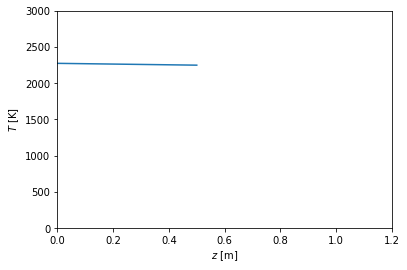

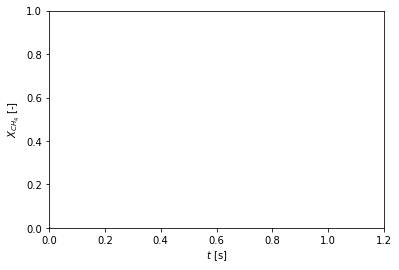

In [18]:
plt.figure()
plt.plot(z2, states2.T)
plt.xlabel('$z$ [m]')
plt.ylabel('$T$ [K]')
plt.axis([0, 1.2, 0, 3000])
plt.show()
#plt.savefig('pfr_T_z.png')

plt.figure()
plt.plot(t2, states2.X[:, downstream_gas.species_index('CH4')])
plt.xlabel('$t$ [s]')
plt.ylabel('$X_{CH_4}$ [-]')
plt.axis([0, 1.2, 0, 1])
plt.show()
#plt.savefig('pfr_XH2_t.png')